In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
%matplotlib inline

In [2]:
os.chdir("C:\\Users\\GL75\\OneDrive\\桌面\\深度學習\\Lab2")

In [3]:
from dataloader import read_bci_data

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device = {device}")

device = cuda


In [4]:
X_train, y_train, X_test, y_test = read_bci_data()

(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)


In [6]:
np.unique(y_train)

array([0., 1.])

In [7]:
batch_size = 270 # bigger, such as 270 (1/4)

In [11]:
lr = 0.001 # the default for AdamW, [0.001, 0.01]
epochs = 300

In [9]:
train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [11]:
a = iter(test_dataloader)
print(next(a)[0][0], next(a)[1][0])

tensor([[[ -8.3359,  -8.7829,  -9.3748,  ...,  -2.1328,  -2.8224,  -2.0885],
         [-10.6524,  -8.4476,  -5.9331,  ...,   0.5607,  -4.1266,  -8.1379]]],
       dtype=torch.float64) tensor(1., dtype=torch.float64)


sample from training data: id = 650


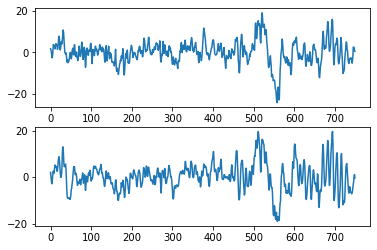

In [12]:
random_num = np.random.randint(0, X_train.shape[0])
print("sample from training data: id = {}".format(random_num))
plt.subplot(211)
plt.plot(X_train[random_num, 0, 0])
plt.subplot(212)
plt.plot(X_train[random_num, 0, 1])

Channel $C=2$  
Timestep $T=750$

In [9]:
class DeepConvNet(nn.Module):
    def __init__(self, activation_fn = nn.ELU()):
        super().__init__()
        self.conv_in = nn.Conv2d(1, 25, (1, 5))
        channels = [25, 25, 50, 100, 200]
        filters = [(2, 1), (1, 5), (1, 5), (1, 5)]
        for i in range(len(channels)-1):
            setattr(self, "conv_" + str(i+1), nn.Sequential(
                nn.Conv2d(channels[i], channels[i+1], filters[i]),
                nn.BatchNorm2d(channels[i+1]), # eps=1e-5, momentum=0.1 as defaults
                activation_fn,
                nn.MaxPool2d((1, 2)),
                nn.Dropout(0.5)
            ))
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(8600, 2) # binary classification
    def forward(self, X):
        output = self.conv_in(X)
        output = self.conv_1(output)
        output = self.conv_2(output)
        output = self.conv_3(output)
        output = self.conv_4(output)
        output = self.flatten(output)
        output = self.dense(output)
        return output

In [14]:
# activation to be tried = ELU, ReLU, LeakyReLU
# optimizer = Adam
# loss function = binary cross-entropy

In [15]:
loss_fn = nn.CrossEntropyLoss()

In [12]:
model = DeepConvNet() # ELU by default
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr = lr)

In [13]:
print(model)

DeepConvNet(
  (conv_in): Conv2d(1, 25, kernel_size=(1, 5), stride=(1, 1))
  (conv_1): Sequential(
    (0): Conv2d(25, 25, kernel_size=(2, 1), stride=(1, 1))
    (1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
  )
  (conv_2): Sequential(
    (0): Conv2d(25, 50, kernel_size=(1, 5), stride=(1, 1))
    (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
  )
  (conv_3): Sequential(
    (0): Conv2d(50, 100, kernel_size=(1, 5), stride=(1, 1))
    (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding

In [17]:
def testing(model, test_dataloader, device):
    model.eval()
    accuracy = 0.0
    with torch.no_grad():
        for (X_batched, y_batched) in test_dataloader:
            X_batched = X_batched.to(device, dtype = torch.float)
            y_batched = y_batched.to(device, dtype = torch.long)
            prediction = model(X_batched)
            accuracy += prediction.max(dim = 1)[1].eq(y_batched).sum().item()
        # calculate the accuracy
        accuracy = accuracy / len(test_dataloader.dataset) * 100
    return accuracy

In [18]:
def training(model, train_dataloader, test_dataloader, loss_fn, optimizer, epochs, device):
    train_acc, test_acc = [], []
    best_test_acc = 0.0
    best_model_weights = None
    for e in range(epochs):
        '''training session'''
        model.train()
        train_loss = 0.0
        accuracy = 0.0
        for (X_batched, y_batched) in train_dataloader:
            # clear the previous gradients
            optimizer.zero_grad()
            X_batched = X_batched.to(device, dtype = torch.float) # make sure it converted to float tensors
            y_batched = y_batched.to(device, dtype = torch.long) # the target variable must be long tensors
            prediction = model(X_batched)
            loss = loss_fn(prediction, y_batched)
            train_loss += loss.item() # use item() to retrieve the value from 1x1 tensor
            accuracy += prediction.max(dim = 1)[1].eq(y_batched).sum().item() # for torch.max, use [1] to get the indices. [0] is the values. torch.eq for equal or not
            # update the weights
            loss.backward()
            optimizer.step()
        # calculate the loss and accuracy
        train_loss /= len(train_dataloader.dataset)
        accuracy = accuracy / len(train_dataloader.dataset) * 100
        if (e+1) % 10 == 0:
            print(f"Epoch {e+1:>3d}: loss = {train_loss:.5f}, acc = {accuracy:.2f}%")
        train_acc.append(accuracy)
        '''testing session'''
        accuracy = testing(model, test_dataloader, device)
        test_acc.append(accuracy)
        if accuracy > best_test_acc:
            best_test_acc = accuracy
            best_model_weights = copy.deepcopy(model.state_dict()) # best model weights are those with the highest "testing" accuracy
    return train_acc, test_acc, best_model_weights

In [19]:
accuracy_list = dict()
accuracy_list['epoch'] = list(range(1, epochs + 1))

# ELU (default)

In [20]:
train_acc, test_acc, best_model_weights = training(model, train_dataloader, test_dataloader, loss_fn, optimizer, epochs, device)
accuracy_list['ELU_train'] = train_acc
accuracy_list['ELU_test'] = test_acc
torch.save(best_model_weights, os.path.join("D://DL_lab2_params/DeepConvNet", 'ELU.pt'))

Epoch  10: loss = 0.00205, acc = 70.09%
Epoch  20: loss = 0.00171, acc = 76.57%
Epoch  30: loss = 0.00169, acc = 78.15%
Epoch  40: loss = 0.00149, acc = 81.39%
Epoch  50: loss = 0.00140, acc = 83.24%
Epoch  60: loss = 0.00135, acc = 83.80%
Epoch  70: loss = 0.00126, acc = 84.81%
Epoch  80: loss = 0.00118, acc = 85.83%
Epoch  90: loss = 0.00111, acc = 86.39%
Epoch 100: loss = 0.00098, acc = 89.17%
Epoch 110: loss = 0.00101, acc = 87.41%
Epoch 120: loss = 0.00105, acc = 87.96%
Epoch 130: loss = 0.00087, acc = 90.00%
Epoch 140: loss = 0.00079, acc = 90.93%
Epoch 150: loss = 0.00074, acc = 91.94%
Epoch 160: loss = 0.00068, acc = 92.69%
Epoch 170: loss = 0.00065, acc = 93.06%
Epoch 180: loss = 0.00056, acc = 93.43%
Epoch 190: loss = 0.00063, acc = 93.61%
Epoch 200: loss = 0.00047, acc = 95.09%
Epoch 210: loss = 0.00040, acc = 95.56%
Epoch 220: loss = 0.00042, acc = 95.65%
Epoch 230: loss = 0.00044, acc = 95.65%
Epoch 240: loss = 0.00043, acc = 95.83%
Epoch 250: loss = 0.00043, acc = 95.83%


# ReLU

In [21]:
model = DeepConvNet(activation_fn = nn.ReLU())
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr = lr)

In [22]:
train_acc, test_acc, best_model_weights = training(model, train_dataloader, test_dataloader, loss_fn, optimizer, epochs, device)
accuracy_list['ReLU_train'] = train_acc
accuracy_list['ReLU_test'] = test_acc
torch.save(best_model_weights, os.path.join("D://DL_lab2_params/DeepConvNet", 'ReLU.pt'))

Epoch  10: loss = 0.00209, acc = 68.15%
Epoch  20: loss = 0.00186, acc = 74.54%
Epoch  30: loss = 0.00179, acc = 75.83%
Epoch  40: loss = 0.00161, acc = 77.96%
Epoch  50: loss = 0.00157, acc = 79.63%
Epoch  60: loss = 0.00148, acc = 81.20%
Epoch  70: loss = 0.00139, acc = 83.33%
Epoch  80: loss = 0.00137, acc = 82.59%
Epoch  90: loss = 0.00117, acc = 85.83%
Epoch 100: loss = 0.00117, acc = 85.93%
Epoch 110: loss = 0.00110, acc = 87.04%
Epoch 120: loss = 0.00107, acc = 88.15%
Epoch 130: loss = 0.00102, acc = 88.06%
Epoch 140: loss = 0.00093, acc = 90.19%
Epoch 150: loss = 0.00093, acc = 90.00%
Epoch 160: loss = 0.00101, acc = 88.33%
Epoch 170: loss = 0.00091, acc = 89.54%
Epoch 180: loss = 0.00082, acc = 90.74%
Epoch 190: loss = 0.00081, acc = 91.57%
Epoch 200: loss = 0.00085, acc = 91.11%
Epoch 210: loss = 0.00073, acc = 91.67%
Epoch 220: loss = 0.00078, acc = 91.11%
Epoch 230: loss = 0.00068, acc = 92.50%
Epoch 240: loss = 0.00064, acc = 92.31%
Epoch 250: loss = 0.00072, acc = 92.04%


# Leaky ReLU

In [23]:
model = DeepConvNet(activation_fn = nn.LeakyReLU())
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr = lr)

In [24]:
train_acc, test_acc, best_model_weights = training(model, train_dataloader, test_dataloader, loss_fn, optimizer, epochs, device)
accuracy_list['LeakyReLU_train'] = train_acc
accuracy_list['LeakyReLU_test'] = test_acc
torch.save(best_model_weights, os.path.join("D://DL_lab2_params/DeepConvNet", 'LeakyReLU.pt'))

Epoch  10: loss = 0.00217, acc = 68.89%
Epoch  20: loss = 0.00191, acc = 74.63%
Epoch  30: loss = 0.00174, acc = 76.85%
Epoch  40: loss = 0.00164, acc = 79.81%
Epoch  50: loss = 0.00166, acc = 78.89%
Epoch  60: loss = 0.00153, acc = 81.30%
Epoch  70: loss = 0.00143, acc = 81.20%
Epoch  80: loss = 0.00137, acc = 82.78%
Epoch  90: loss = 0.00131, acc = 84.72%
Epoch 100: loss = 0.00126, acc = 84.54%
Epoch 110: loss = 0.00127, acc = 84.63%
Epoch 120: loss = 0.00117, acc = 86.57%
Epoch 130: loss = 0.00106, acc = 87.59%
Epoch 140: loss = 0.00094, acc = 88.98%
Epoch 150: loss = 0.00093, acc = 89.26%
Epoch 160: loss = 0.00096, acc = 88.70%
Epoch 170: loss = 0.00097, acc = 88.24%
Epoch 180: loss = 0.00090, acc = 89.81%
Epoch 190: loss = 0.00078, acc = 91.67%
Epoch 200: loss = 0.00086, acc = 90.00%
Epoch 210: loss = 0.00077, acc = 91.57%
Epoch 220: loss = 0.00070, acc = 92.13%
Epoch 230: loss = 0.00081, acc = 90.65%
Epoch 240: loss = 0.00071, acc = 92.69%
Epoch 250: loss = 0.00065, acc = 93.33%


In [25]:
df_acc = pd.DataFrame(accuracy_list)

In [26]:
for col in df_acc.columns[1: ]:
    print("The maximum {}ing accuracy of the model using {} is: {:.2f}%".format(col.split("_")[1], col.split("_")[0], df_acc[col].max()))

The maximum training accuracy of the model using ELU is: 97.96%
The maximum testing accuracy of the model using ELU is: 81.57%
The maximum training accuracy of the model using ReLU is: 94.81%
The maximum testing accuracy of the model using ReLU is: 82.96%
The maximum training accuracy of the model using LeakyReLU is: 94.54%
The maximum testing accuracy of the model using LeakyReLU is: 81.30%


In [30]:
activation = {"ELU.pt": nn.ELU(), "ReLU.pt": nn.ReLU(), "LeakyReLU.pt": nn.LeakyReLU()}
for param_file in os.listdir("D://DL_lab2_params/DeepConvNet"):
    model = DeepConvNet(activation[param_file])
    model.load_state_dict(torch.load(os.path.join("D://DL_lab2_params/DeepConvNet", param_file), map_location = device))
    model.to(device)
    acc = testing(model, test_dataloader, device)
    print(f"The testing accuracy of the model using {param_file[:-3]} is: {acc:.2f}%")

The testing accuracy of the model using ELU is: 81.57%
The testing accuracy of the model using LeakyReLU is: 81.30%
The testing accuracy of the model using ReLU is: 82.96%


In [28]:
def plot_result(df):
    fig = plt.figure(figsize = (15, 10))
    for config in df.columns[1:]:
        plt.plot(df.columns[0], config, data = df)
    plt.legend()
    plt.title("Comparison Figure (via Accuracy)")
    plt.savefig("DeepConvNet_result.png")

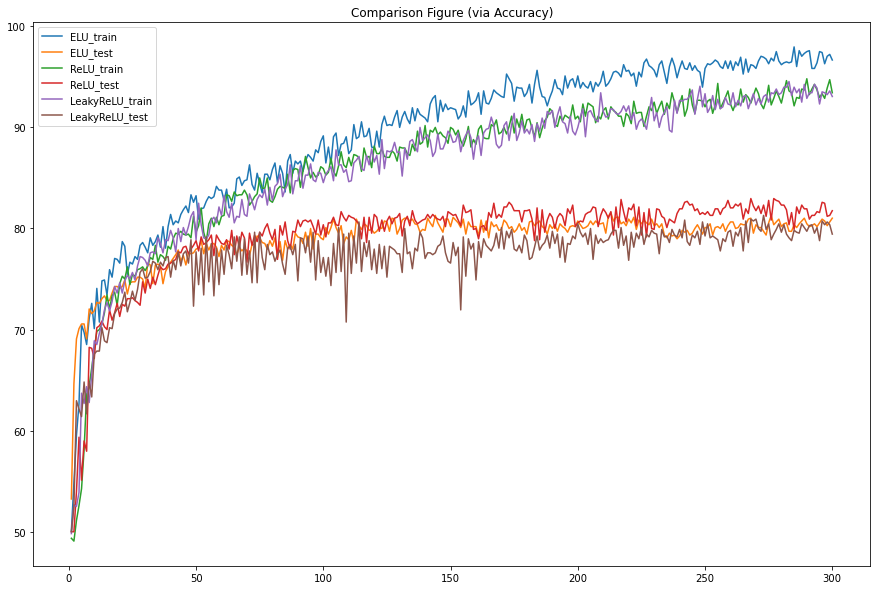

In [29]:
plot_result(df_acc)